In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# One-shot learning with Siamese Network


Adapted from [this paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

More info:
* https://paperswithcode.com/paper/siamese-neural-networks-for-one-shot-image
* https://github.com/danielelvs/one-shot/blob/main/One_Shot_npy.ipynb
* https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e
* https://github.com/maticvl/dataHacker/blob/master/pyTorch/014_siameseNetwork.ipynb
* https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb
* https://github.com/moradna/Siamese-Neural-Networks-for-One-shot-Image-Recognition
https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf#page=4.65

### Dataset **[Olivetti Faces](https://www.openml.org/search?type=data&status=active&id=41083)**

- Author: AT&T Laboratories Cambridge
- Source: [https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html](http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)
- Date: 1992-1994

> This dataset contains a set of face images taken between April 1992 and April 1994 at AT&T Laboratories Cambridge. <br /><br />
There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The image is quantized to 256 grey levels and stored as unsigned 8-bit integers; the loader will convert these to floating point values on the interval [0, 1], which are easier to work with for many algorithms. <br /><br />
The “target” for this database is an integer from 0 to 39 indicating the identity of the person pictured; however, with only 10 examples per class, this relatively small dataset is more interesting from an unsupervised or semi-supervised perspective. <br /><br />
The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

## 1. Setup

In [ ]:
# If True, test is running on Colab. Otherwise, test if assumed to be offline.
TEST_ON_COLAB = True
FOLDERNAME = "Colab Notebooks/face-verification_one-shot" # only used if TEST_ON_COLAB is True
SEED = 42 # seed for reproducibility

assert not (FOLDERNAME is None and TEST_ON_COLAB), "FOLDERNAME has to be set if TEST_ON_COLAB is True"

In [ ]:
# @title ### Imports

!pip install pillow

import os
import numpy as np
import random
# import pickle
# import datetime
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torch import optim
# from PIL import Image
# from PIL import ImageOps

# Set the device to be used for training (cuda:0 if there is a GPU available, otherwise cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seed experiments
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
# @title ### Create dataset structure

DATASET = "olivetti_faces_npy"

assert not (DATASET is None), "Please, set the dataset name"

# Create dataset directory
if TEST_ON_COLAB:
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive

    drive.mount('/content/drive')
    cache_dir = f"/content/drive/My Drive/{FOLDERNAME}/dataset/{DATASET}"
else:
    cache_dir =  f"dataset/{DATASET}"

os.makedirs(cache_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title ### Get dataset

X_file_path = f"{cache_dir}/X.npy"
y_file_path = f"{cache_dir}/y.npy"

# Check if the dataset files already exist
if not (os.path.exists(X_file_path) and os.path.exists(y_file_path)):
    X, y = fetch_olivetti_faces(download_if_missing=True, return_X_y=True)

    # Save the dataset as numpy arrays
    np.save(X_file_path, X.astype(np.float32))
    np.save(y_file_path, y)
    print(f"Dataset downloaded and saved successfully to {cache_dir}.")
else:
    X = np.load(X_file_path, allow_pickle=True)
    y = np.load(y_file_path, allow_pickle=True)
    print(f"Dataset already exists in {cache_dir}. Skipping download.")

H = W = int(np.sqrt(X.shape[1]))
X = X.reshape(-1, H, W)
print(f"#samples={X.shape[0]} min/max={X.min()}/{X.max()}")
print(f"image size={H}x{W}")
print(f"#classes={len(np.unique(y))}")


Dataset already exists in /content/drive/My Drive/Colab Notebooks/face-verification_one-shot/dataset/olivetti_faces_npy. Skipping download.
#samples=400 min/max=0.0/1.0
image size=64x64
#classes=40


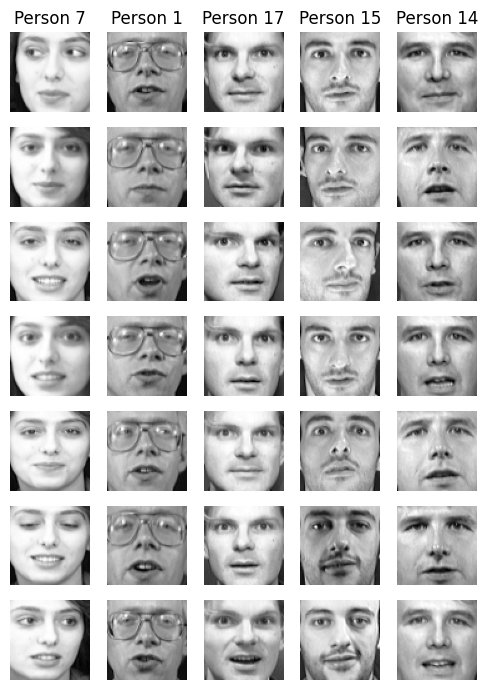

In [ ]:
# @title ### Displays a few samples

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
num_classes_to_sample = 5
num_classes = len(np.unique(y))
classes = random.sample(range(num_classes), num_classes_to_sample)
samples_per_class = 7

fig, axs = plt.subplots(samples_per_class, num_classes_to_sample, figsize=(5, 7))
for i, cls in enumerate(classes):
    idxs = np.flatnonzero(y == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for j, idx in enumerate(idxs):
        axs[j, i].imshow(X[idx], cmap='gray')
        axs[j, i].axis('off')
    axs[0, i].set_title(f"Person {cls}")
plt.tight_layout()
plt.show()

train_classes=[ 0  1  3  5  6  7  8  9 10 12 13 14 16 17 18 19 20 22 23 26 27 29 30 31
 32 33 34 35 36 39]
val_classes=[ 4 11 24 25 38]
test_classes=[ 2 15 21 28 37]
X_train=(300, 64, 64)
y_train=(300,)
X_val=(50, 64, 64)
y_val=(50,)
X_test=(50, 64, 64)
y_test=(50,)


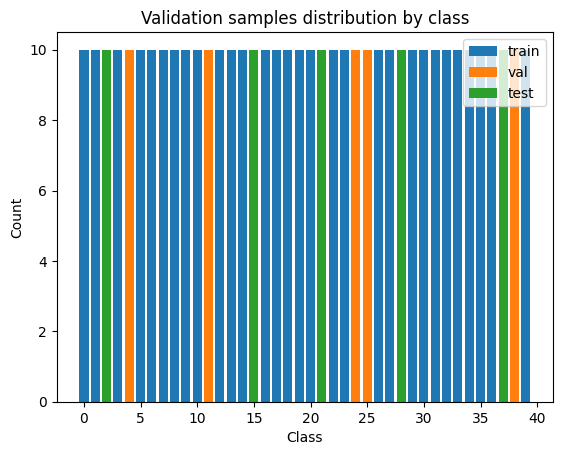

In [ ]:
# @title ### Split the dataset

classes = np.unique(y) # identify unique classes
num_classes = len(classes)

# Split size
num_classes_test = 5
num_classes_val = 5
num_classes_train = num_classes - num_classes_test - num_classes_val

# Dataset
X = X.astype(np.float32)
y = y.astype(int)

# Shuffle dataset
indices = np.arange(len(y))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Split classes
train_classes = np.random.choice(classes, num_classes_train, replace=False) # select random classes for training
train_classes.sort()
rem_classes = np.setdiff1d(classes, train_classes) # remaining classes
val_classes = np.random.choice(rem_classes, num_classes_val, replace=False) # select random classes for validation
val_classes.sort()
test_classes = np.setdiff1d(rem_classes, val_classes) # remaining classes
print(f"train_classes={train_classes}")
print(f"val_classes={val_classes}")
print(f"test_classes={test_classes}")

train_idx = np.isin(y, train_classes)
val_idx = np.isin(y, val_classes)
test_idx = np.isin(y, test_classes)

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(f"X_train={X_train.shape}")
print(f"y_train={y_train.shape}")
print(f"X_val={X_val.shape}")
print(f"y_val={y_val.shape}")
print(f"X_test={X_test.shape}")
print(f"y_test={y_test.shape}")

np.save(os.path.join(cache_dir, "X_train.npy"), X_train)
np.save(os.path.join(cache_dir, "y_train.npy"), y_train)
np.save(os.path.join(cache_dir, "X_val.npy"), X_val)
np.save(os.path.join(cache_dir, "y_val.npy"), y_val)
np.save(os.path.join(cache_dir, "X_test.npy"), X_test)
np.save(os.path.join(cache_dir, "y_test.npy"), y_test)

# Plot validation samples distribution by class
from collections import Counter

counter_train, counter_val, counter_test = Counter(y_train), Counter(y_val), Counter(y_test)
plt.bar(counter_train.keys(), counter_train.values(), label='train')
plt.bar(counter_val.keys(), counter_val.values(), label='val')
plt.bar(counter_test.keys(), counter_test.values(), label='test')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Validation samples distribution by class')
plt.legend()
plt.show()

## 2. Classes

In [ ]:
# @title ### Data Class

class TrainDataset(Dataset):
    """
    Data class for Siamese Network training.
    """
    def __init__(self, X, y, size=None, transform=None):
        """
        Initialize the dataset with the images and their labels.

        Args:
        - X: Images.
        - y: Labels.
        - transform: Transform to apply to the images.
        """

        self.X = X
        self.y = y
        self.transform = transform
        self.size = size if size is not None else X.shape[0]

    def __getitem__(self, idx):
        """
        Selects two random images and returns the data.

        Args:
        - idx: Dummy variable.
        Returns:
        - tuple: Two random images and their labels.
        """

        idx1 = np.random.randint(0, len(self.X))
        # idx1 = random.randint(0, len(self.X) - 1)
        # image1 = Image.fromarray(self.X[idx1], mode='L')
        image1 = torch.tensor(self.X[idx1:idx1+1], dtype=torch.float32)
        # image1 = self.X[idx1][np.newaxis]
        label1 = self.y[idx1]

        # Sample a positive or negative image
        should_match = np.random.choice([True, False])#random.randint(0, 1) # we need to approximately 50% of images to be in the same class
        mask_candidates = (self.y == label1) if should_match else (self.y != label1)
        mask_candidates[idx1] = False # Prevent sampling the same sample
        idx_candidates = np.where(mask_candidates)[0]
        idx2 = np.random.choice(idx_candidates)

        # if should_match:
        #     while True: # look until the same class image is found
        #         idx2 = random.randint(0, len(self.X) - 1)
        #         if label1 == self.y[idx2]:
        #             break
        # else:
        #     while True: # look until a different class image is found
        #         idx2 = random.randint(0, len(self.X) - 1)
        #         if label1 != self.y[idx2]:
        #             break

        # image2 = Image.fromarray(self.X[idx2], mode='L')
        image2 = torch.tensor(self.X[idx2:idx2+1], dtype=torch.float32)
        # image2 = self.X[idx2][np.newaxis]
        label2 = self.y[idx2]

        if self.transform is not None:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        return image1, image2, torch.tensor(1 - should_match, dtype=torch.float32)

    def __len__(self):
        """ Returns the size of the dataset."""

        return self.size


class EvalDataset(Dataset):
    """
    Data class for Siamese Network evaluation.
    """
    def __init__(self, X, y, transform=None):
        """
        Initialize the dataset with the images and their labels.

        Args:
        - X: Images.
        - y: Labels.
        - transform: Transform to apply to the images.
        """

        self.X = X
        self.y = y
        self.transform = transform

    def __getitem__(self, idx):
        """
        Selects a single image and returns the data.

        Args:
        - idx: Index of the image.
        Returns:
        - tuple: A single image and its label.
        """

        # image = Image.fromarray(self.X[index], mode='L')
        image = torch.tensor(self.X[idx:idx+1], dtype=torch.float32)
        label = self.y[idx]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        """ Returns the size of the dataset."""

        return len(self.X)

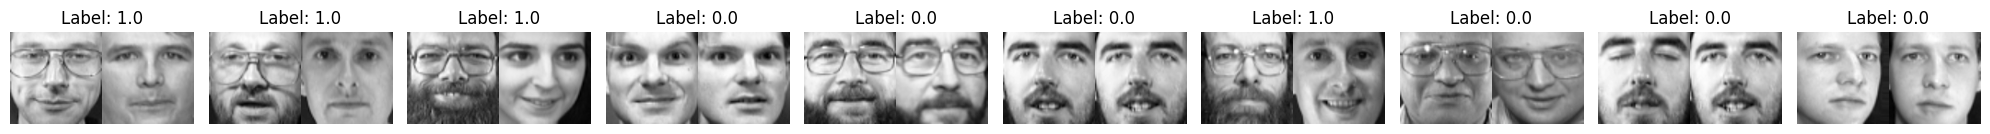

#positive samples=4.0
#negative samples=6.0


In [ ]:
# @title ### Plot a few training samples using dataloaders
num_samples = 10
transformation = transforms.Compose([transforms.Resize((100, 100))])

train_dataset = TrainDataset(X=X_train, y=y_train, transform=transformation)
train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=1, batch_size=num_samples)

images1, images2, labels = next(iter(train_dataloader))
images = torch.cat((images1, images2), axis=3)
images = images.numpy().squeeze(axis=1)
labels = labels.numpy()

# Plot the images
fig, axs = plt.subplots(1, num_samples, figsize=(2*num_samples, 2), dpi=100)
for i in range(num_samples):
    axs[i].imshow(images[i], cmap='gray')
    axs[i].set_title(f"Label: {labels[i]}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()

print(f"#positive samples={labels.sum()}")
print(f"#negative samples={(1-labels).sum()}")

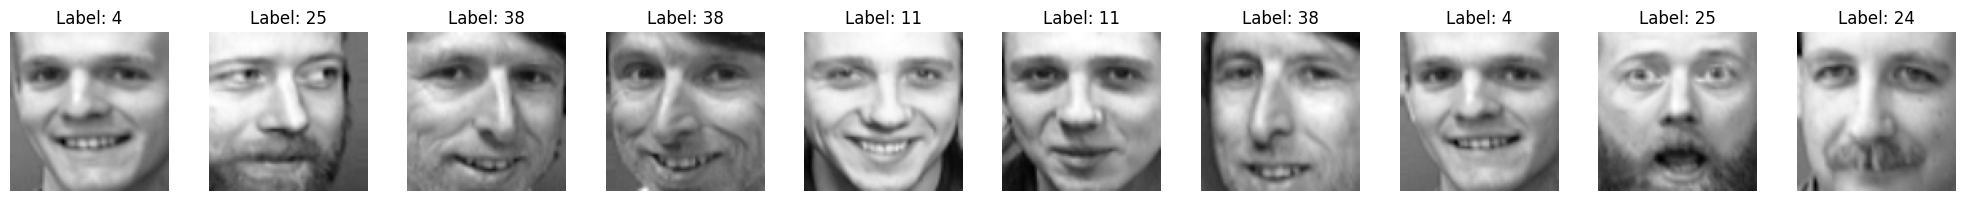

In [ ]:
# @title ### Plot a few validation samples using dataloaders

num_samples = 10
transformation = transforms.Compose([transforms.Resize((100, 100))])

val_dataset = EvalDataset(X=X_val, y=y_val, transform=transformation)
val_dataloader = DataLoader(val_dataset, shuffle=True, num_workers=1, batch_size=num_samples)

images, labels = next(iter(val_dataloader))
images = images.numpy().squeeze(axis=1)
labels = labels.numpy()

# Plot the images
fig, axs = plt.subplots(1, num_samples, figsize=(2*num_samples, 2), dpi=100)
for i in range(num_samples):
    axs[i].imshow(images[i], cmap='gray')
    axs[i].set_title(f"Label: {labels[i]}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# @title ### Network Class

class Network(nn.Module):
    """
    Siamese Network.
    """
    def __init__(self, feat_dim=512):
        """
        Initialize the network.
        """
        super(Network, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True)
        ) # 1x1x384 for 100x100 input

        self.fc1 = nn.Sequential(
            nn.Linear(384, feat_dim),
        )

    def forward_once(self, x):
        """
        Forward pass once.

        Args:
        - x: Input.

        Returns:
        - Output.
        """
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1) # batches x feat_dim
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        """
        Forward pass.

        Args:
        - input1: First input.
        - input2: Second input

        Returns:
        - Output1.
        - Output2.
        """
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## 3. Training

In [ ]:
# @title ### Contrastive Loss Class

class ContrastiveLoss(torch.nn.Module):
  """ Contrastive loss function. """

  def __init__(self, margin=2.0):
    """
    Initialize the loss function.

    Args:
    - margin: Margin.
    """
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    """
    Forward pass.

    Args:
    - output1: First network output.
    - output2: Second network output.
    - label: Label (binary).

    Returns:
    - Loss.
    """
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
    loss_contrastive = torch.mean(
        (1 - label) * torch.pow(euclidean_distance, 2) +
        label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
    )
    return loss_contrastive

In [ ]:
# @title ### Evaluator Class

from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

class Evaluator:
    def __init__(self, labels, k_shot=1, num_runs=None, device=None):
        """
        Initialize the evaluator.

        Args:
        - labels: Labels.
        - k_shot: Number of samples per class to compose the support.
        - num_runs: Number of evaluation runs.
        """

        if num_runs is None:
            num_runs = len(labels) // len(np.unique(labels)) # avg. samples per class

        self.device = device if device is not None else "cpu"
        self.k_shot = k_shot
        self.num_runs = num_runs

        # Setup support and query
        self.support_idxs = []
        self.query_idxs = []
        for _ in range(num_runs):
            support_idxs, query_idxs = self._split_into_query_support(labels, k_shot)
            self.support_idxs.append(support_idxs)
            self.query_idxs.append(query_idxs)

    def _split_into_query_support(self, labels, k):
        # Get the unique labels
        labels_unique = np.unique(labels)

        # Initialize lists to hold the support and query indices
        support_idxs = []
        query_idxs = []

        # Sample k indices from each label/class
        for label in labels_unique:
            cls_idxs = np.where(labels == label)[0]

            # Support indices
            cls_support_idxs = resample(cls_idxs, replace=False, n_samples=k)

            # Determine the query indices (those not in the support set)
            cls_query_idxs = np.setdiff1d(cls_idxs, cls_support_idxs)

            support_idxs.extend(cls_support_idxs)
            query_idxs.extend(cls_query_idxs)

        return support_idxs, query_idxs

    def eval(self, model, dataloader, k=3):
        """
        Evaluate the model on the given dataloader.

        Args:
        - model: The model to evaluate.
        - dataloader: The dataloader to use for evaluation.
        - k: The number of nearest neighbors (KNN) to consider.

        Returns:
        - accuracy: The accuracy of the model on the given dataloader.
        """

        assert 1 <= k <= self.k_shot, "k must be less than or equal to k_eval"

        # Inference
        outputs = []
        labels = []
        model.eval()
        with torch.no_grad():
            for idx, (image, label) in enumerate(dataloader, 0):
                output = model.forward_once(image.to(self.device))
                outputs.append(output.cpu().numpy())
                labels.append(label.numpy())
        outputs = np.vstack(outputs)
        labels = np.concatenate(labels)

        # KNN
        hits = 0
        num_queries = 0
        neigh = KNeighborsClassifier(n_neighbors=k)
        for support_idxs, query_idxs in zip(self.support_idxs, self.query_idxs):
            neigh.fit(outputs[support_idxs], labels[support_idxs])
            labels_pred = neigh.predict(outputs[query_idxs])
            hits += np.sum(labels_pred == labels[query_idxs])
            num_queries += len(query_idxs)
        accuracy = hits / num_queries

        return accuracy

In [ ]:
# @title ### Create the variables

# hyperparameters
# feat_dim = 128
feat_dim = 128
# learning_rate = 5e-04
learning_rate = 0.0001
num_epochs = 100
batch_size = 32
num_workers = 2 # for parallel processing
num_runs = 100 # number of evaluations for validation/test

#https://github.com/pytorch/vision/blob/main/torchvision/transforms/transforms.py
transformation = transforms.Compose([transforms.Resize((100, 100))])#, transforms.ToTensor()])

train_dataset = TrainDataset(X=X_train, y=y_train, transform=transformation)
train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=num_workers, batch_size=batch_size)

val_dataset = EvalDataset(X=X_val, y=y_val, transform=transformation)
val_dataloader = DataLoader(val_dataset, shuffle=False, num_workers=num_workers, batch_size=batch_size)

test_dataset = EvalDataset(X=X_test, y=y_test, transform=transformation)
test_dataloader = DataLoader(test_dataset, shuffle=False, num_workers=num_workers, batch_size=batch_size)

model = Network(feat_dim=feat_dim).to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

evaluator = Evaluator(labels=y_val, k_shot=1, num_runs=num_runs, device=device)

In [ ]:
# @title ### Training

# def smd(x, y):
#     """
#     Calculates the Cohen's d statistic for two samples (Standardized Mean Differences).
#     """
#     nx = x.size
#     ny = y.size
#     dof = nx + ny - 2
#     return (x.mean() - y.mean()) / np.sqrt(((nx - 1) * x.std(ddof=1) ** 2 + (ny - 1 ) * y.std(ddof=1) ** 2) / dof)

def train(model, train_dataloader, val_dataloader, num_epochs, criterion, optimizer, device):
    """
    Trains the model for a given number of epochs.

    Args:
    - model: The model to train.
    - train_dataloader: The dataloader to use for training.
    - val_dataloader: The dataloader to use for validation.
    - num_epochs: The number of epochs to train for.
    - criterion: The loss function to use.
    - optimizer: The optimizer to use.
    - device: The device to use for training.
    """

    model.train()
    best_loss = float("inf")
    best_loss_history = []
    loss_history = []

    # best_smd = -float("inf")
    best_epoch = -1
    best_accuracy = -1
    accuracy_history = []
    # smd_chart = []

    # Training/val loop
    iteration = 0
    for epoch in range(num_epochs):
        # Training section
        model.train()
        for idx, (image1, image2, label) in enumerate(train_dataloader, 0):
            # print(image1.shape)
            image1, image2, label = image1.to(device), image2.to(device), label.to(device)
            optimizer.zero_grad()
            output1, output2 = model(image1, image2)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

            loss_value = loss_contrastive.item()
            if loss_value < best_loss:
                best_loss = loss_value
            best_loss_history.append(best_loss)
            loss_history.append(loss_value)

            # Display current result
            if idx % 10 == 0:
                loss_mean = np.mean(loss_history[-10:]) # 10 last loss values
                # print(f"Epoch {epoch} Loss {loss_mean:.4f} (Best Epoch {best_epoch} Best SMD {best_smd:3f})")
                print(f"Epoch {epoch} Loss {loss_mean:.4f} (Best Epoch {best_epoch} Best Accuracy {best_accuracy:3f})")

            iteration += 1

        # Validation section
        accuracy = evaluator.eval(model, val_dataloader, k=1)
        accuracy_history.append(accuracy)
        # smd_chart.append(smd)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), "best-model.pth")

    return best_epoch, best_accuracy, best_loss_history, loss_history, accuracy_history

best_epoch, best_accuracy, best_loss_history, loss_history, accuracy_history = train(model, train_dataloader, val_dataloader, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer, device=device)
print(f"Best Epoch {best_epoch} Best Accuracy {best_accuracy:3f}")

Epoch 0 Loss 2.0236 (Best Epoch -1 Best Accuracy -1.000000)
Epoch 1 Loss 1.6367 (Best Epoch 0 Best Accuracy 0.538444)
Epoch 2 Loss 1.4421 (Best Epoch 0 Best Accuracy 0.538444)
Epoch 3 Loss 1.4113 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 4 Loss 1.3299 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 5 Loss 1.2937 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 6 Loss 1.2867 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 7 Loss 1.1890 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 8 Loss 1.2409 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 9 Loss 1.1893 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 10 Loss 1.1606 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 11 Loss 1.1683 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 12 Loss 1.1213 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 13 Loss 1.1694 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 14 Loss 1.1502 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 15 Loss 1.1696 (Best Epoch 2 Best Accuracy 0.542000)
Epoch 16 Loss 1.1699 (Best Epoch 2 Best Accuracy 0.542000)
Epoch

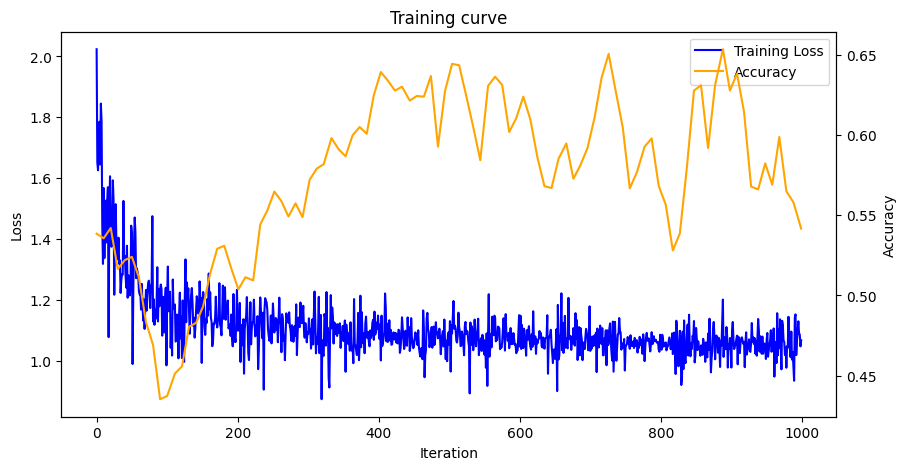

In [ ]:
# @title Training curve
iterations_val = np.linspace(0, len(loss_history) - 1, num_epochs, dtype=int)

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(loss_history, "b-", label="Training Loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Iteration")

ax2 = ax1.twinx()
ax2.plot(iterations_val, accuracy_history, "-", label="Accuracy", color="orange")
ax2.set_ylabel("Accuracy")

handle1, label1 = ax1.get_legend_handles_labels()
handle2, label2 = ax2.get_legend_handles_labels()

handles = handle1 + handle2
labels = label1 + label2
ax1.legend(handles, labels, loc='upper right')
plt.title("Training curve")
plt.show()

## 4. One-shot evaluation

In [ ]:
# @title Metrics
# load saved best model
model.load_state_dict(torch.load("best-model.pth", weights_only=True))

evaluator = Evaluator(labels=y_test, k_shot=1, num_runs=num_runs, device=device)
accuracy = evaluator.eval(model, test_dataloader, k=1)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6366666666666667


In [ ]:
# @title Display test samples
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

outputs = []
images = []
labels = []
model.eval()
with torch.no_grad():
    for image, label in test_dataloader:
        images.append(image.numpy())
        labels.append(label.numpy())
        output = model.forward_once(image.to(device))
        outputs.append(output.cpu().numpy())
images = np.concatenate(images).squeeze(axis=1)
outputs = np.vstack(outputs)
labels = np.concatenate(labels)

# KNN
k = 5
pairwise_distances = squareform(pdist(np.vstack(outputs), metric='euclidean'))
neigh = NearestNeighbors(n_neighbors=k, metric='precomputed')
neigh.fit(pairwise_distances)
distances, indices = neigh.kneighbors() # Encontra os 5 vizinhos mais próximos para cada ponto


In [ ]:
# @title Plot samples and distances

num_samples = len(indices)

# Plot the images
fig, axs = plt.subplots(num_samples, k+1, figsize=(2*(k+1), 2*num_samples), dpi=100)
for i in range(num_samples):
    axs[i, 0].imshow(images[i], cmap='gray')
    axs[i, 0].set_title(f"Query label: {labels[i]}")
    axs[i, 0].axis('off')
    for j in range(1, k+1):
        idx = indices[i, j-1]
        axs[i, j].imshow(images[idx], cmap='gray')
        axs[i, j].set_title(f"{labels[idx]} ({distances[i, j-1]:.4f})")
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title positivo-negativo
num_samples = len(indices)
fig, axs = plt.subplots(num_samples, 3, figsize=(6, 2*num_samples), dpi=100)
for i in range(num_samples):
    idx_positives = np.where(labels == labels[i])[0]
    idx_negatives = np.where(labels != labels[i])[0]
    idx_pos = np.random.choice(idx_positives)
    idx_neg = np.random.choice(idx_negatives)
    axs[i, 0].imshow(images[i], cmap='gray')
    axs[i, 0].set_title(f"Query label: {labels[i]}")
    axs[i, 0].axis('off')

    # positive
    axs[i, 1].imshow(images[idx_pos], cmap='gray')
    axs[i, 1].set_title(f"pos.({pairwise_distances[i, idx_pos]:.4f})")
    axs[i, 1].axis('off')

    # negative
    axs[i, 2].imshow(images[idx_neg], cmap='gray')
    axs[i, 2].set_title(f"neg.({pairwise_distances[i, idx_neg]:.4f})")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.



---



In [ ]:
# Carregar o modelo salvo
model.load_state_dict(torch.load("best-model.pth", weights_only=True))

# Criar o avaliador
evaluator = Evaluator(labels=y_test, k_shot=3, num_runs=num_runs, device=device)

# Avaliar o modelo
accuracy = evaluator.eval(model, test_dataloader, k=1)

# Imprimir a acurácia
print(f"Accuracy: {accuracy}")

Accuracy: 0.8285714285714286


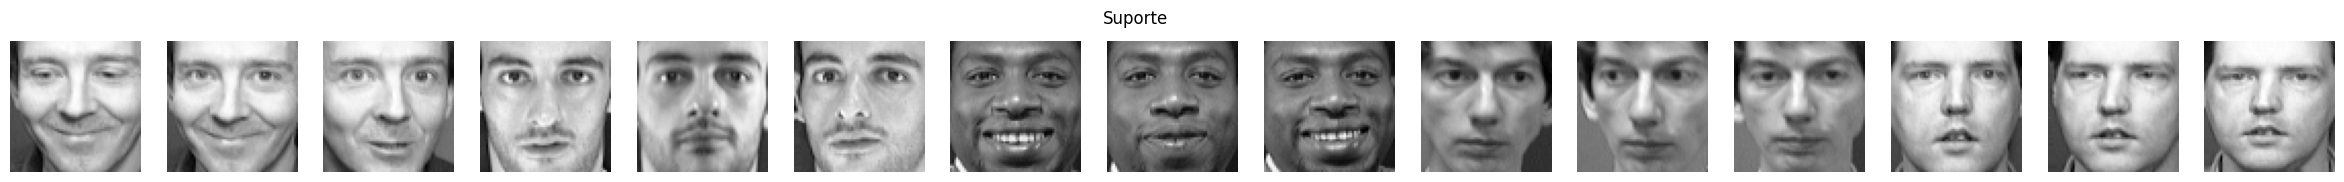

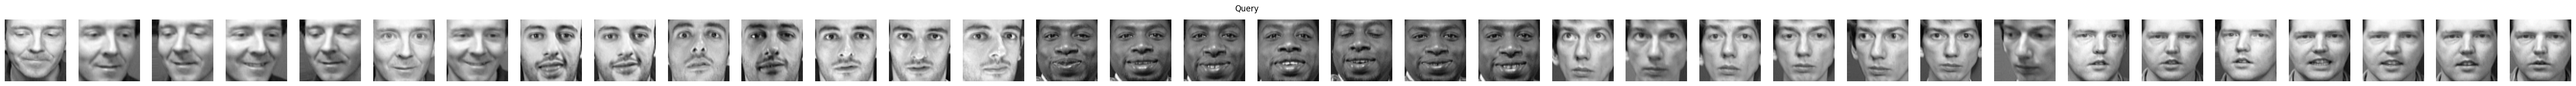

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Obter os índices de suporte e query para uma execução específica
support_idxs = evaluator.support_idxs[0]  # Use o índice 0 para a primeira execução
query_idxs = evaluator.query_idxs[0]

# Obter os dados de suporte e query usando os índices
support_data = X_test[support_idxs]
query_data = X_test[query_idxs]

# Criar uma figura e eixos para o suporte
fig_support, axs_support = plt.subplots(1, len(support_data), figsize=(2 * len(support_data), 2))
fig_support.suptitle('Suporte')

# Criar uma figura e eixos para a query
fig_query, axs_query = plt.subplots(1, len(query_data), figsize=(2 * len(query_data), 2))
fig_query.suptitle('Query')

# Plotar as imagens de suporte
for i, img in enumerate(support_data):
    axs_support[i].imshow(img, cmap='gray')
    axs_support[i].axis('off')

# Plotar as imagens de query
for i, img in enumerate(query_data):
    axs_query[i].imshow(img, cmap='gray')
    axs_query[i].axis('off')

# Exibir os gráficos
plt.show()

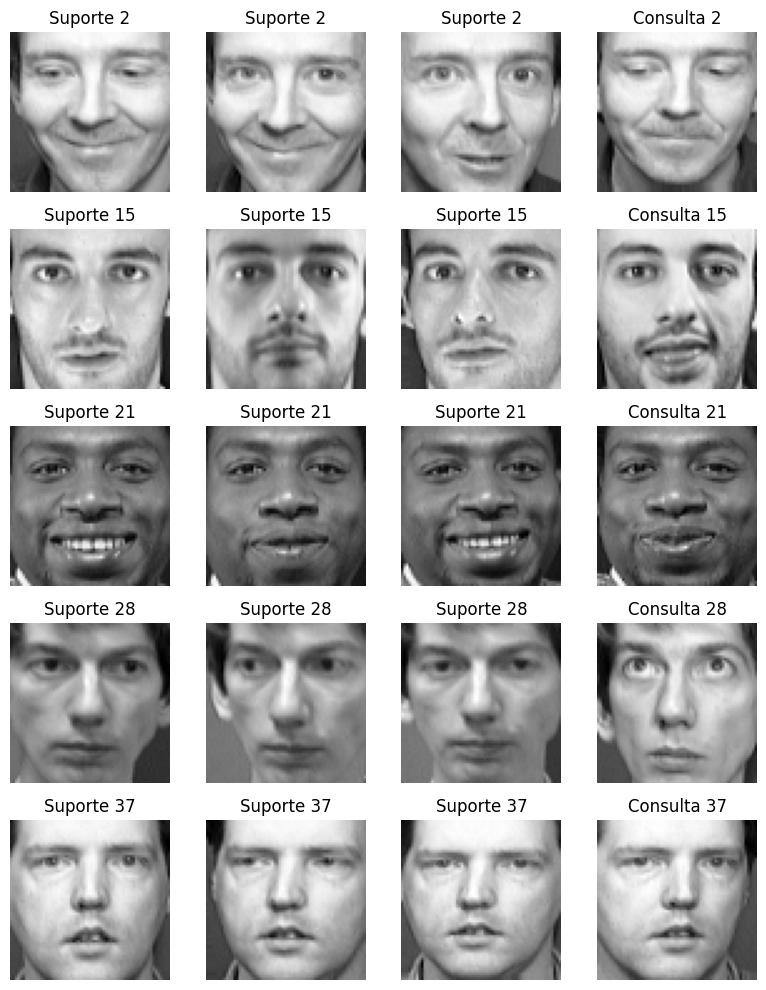

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ... (código anterior para criar o Evaluator e obter os índices de suporte e query) ...

# Obter os índices de suporte e query para uma execução específica
support_idxs = evaluator.support_idxs[0]  # Use o índice 0 para a primeira execução
query_idxs = evaluator.query_idxs[0]

# Obter os dados de suporte e query usando os índices
support_data = X_test[support_idxs]
query_data = X_test[query_idxs]
support_labels = y_test[support_idxs]
query_labels = y_test[query_idxs]

# Criar uma figura e eixos
fig, axs = plt.subplots(len(np.unique(support_labels)), evaluator.k_shot + 1, figsize=(2 * (evaluator.k_shot + 1), 2 * len(np.unique(support_labels))))

# Iterar sobre as classes de suporte
for i, support_label in enumerate(np.unique(support_labels)):
    # Obter os índices das imagens de suporte para a classe atual
    support_class_idxs = np.where(support_labels == support_label)[0]

    # Plotar as imagens de suporte para a classe atual
    for j, idx in enumerate(support_class_idxs):
        axs[i, j].imshow(support_data[idx], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Suporte {support_label}")

    # Obter os índices das imagens de consulta para a classe atual
    query_class_idxs = np.where(query_labels == support_label)[0]

    # Plotar a primeira imagem de consulta para a classe atual
    if len(query_class_idxs) > 0:
        query_idx = query_class_idxs[0]
        axs[i, evaluator.k_shot].imshow(query_data[query_idx], cmap='gray')
        axs[i, evaluator.k_shot].axis('off')
        axs[i, evaluator.k_shot].set_title(f"Consulta {support_label}")

plt.tight_layout()
plt.show()



---





1.   Inserir no escopo de etapas a geração de imagens
2.   Avaliação, todos devem ser avaliados.

